# TFIDF

In [1]:
import pandas as pd
import numpy as np

# feature engineering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron

# metrics for evaluation
from sklearn.metrics import jaccard_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import torch

# visualization libs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

C:\Users\hp\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Feature Engineering

In [2]:
full_df = pd.read_csv(r'./cleaned_data/full_file.csv')
full_df.head()

full_df = full_df[['reviewText','class']].sample(3500000)
full_df.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_13280\2638814835.py:1: DtypeWarning: Columns (9,10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  full_df = pd.read_csv(r'./cleaned_data/full_file.csv')


,reviewText,class
2540262,i bought it to salvage the fur suit. the fur i...,0
1404400,pros: it works. put the plate inside your case...,1
4385336,so before buying this hard drive i read all th...,0
3911627,i love these shoes! they are amazing. i got pu...,1
8613426,this stand works very well and is easy to asse...,0


In [3]:
vectorization = TfidfVectorizer(analyzer = 'word', min_df=0.0, max_features=512)
reviews = full_df['reviewText'].to_list()
X = vectorization.fit_transform(reviews).toarray()

X_train, X_test, y_train, y_test = train_test_split(X, full_df['class'], test_size = 0.2, random_state = 0)

In [4]:
# Convert to PyTorch tensors
X_train_tfidf = torch.tensor(X_train, dtype=torch.float32)
X_test_tfidf = torch.tensor(X_test, dtype=torch.float32)
y_train_tfidf = torch.tensor(np.array(y_train), dtype=torch.float32)
y_test_tfidf = torch.tensor(np.array(y_test), dtype=torch.float32)


In [5]:
import pickle

# Save the model to a file using pickle
with open(r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\TFIDF_vectorization_v2.pkl', 'wb') as file:
    pickle.dump(vectorization, file)
    


In [6]:
def get_stats(y_pred, model_name):
    jacard = round(jaccard_score(y_test, y_pred, average='samples') * 100, 4)
    hamming = round(hamming_loss(y_pred, y_test) * 100, 4)
    print("Results for " + model_name)
    print("Jacard score: " + str(jacard))
    print("Hamming loss: " + str(hamming))
    print()

In [7]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

## Modeling

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score

In [16]:
max_len = 512  # Set maximum sequence length
batch_size = 8
num_epochs = 20
learning_rate = .0001
input_size = X_train_tfidf.shape[1]

In [10]:
max_len

512

In [11]:
import torch
torch.cuda.empty_cache()


In [12]:

# class SequentialModel(nn.Module):
#     def __init__(self, input_dim):
#         super(SequentialModel, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)  # Output dimension is 1 for binary classification

#     def forward(self, x):
#         out = torch.sigmoid(self.linear(x))  # Sigmoid activation for logistic regression
#         return out
    
class SequentialModel(nn.Module):
    def __init__(self, input_dim):
        super(SequentialModel, self).__init__()
        self.seq_model = nn.Sequential(
            nn.Linear(input_size, 128, bias=False),
            nn.Dropout(p=0.5),
#             nn.Linear(256, 128),
#             nn.BatchNorm1d(128),  # BatchNorm layer after the first linear layer
            nn.ReLU(),
#             nn.Dropout(p=0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):

        return self.seq_model(inputs)

# Instantiate the model
model = SequentialModel(input_dim=max_len)

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Create DataLoaders
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(X_test, batch_size=batch_size)


In [13]:
print(model)

SequentialModel(
  (seq_model): Sequential(
    (0): Linear(in_features=512, out_features=128, bias=False)
    (1): Dropout(p=0.5, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=1, bias=True)
    (4): Sigmoid()
  )
)


In [14]:
X_train_tfidf, y_train_tfidf = X_train_tfidf.to(device), y_train_tfidf.to(device)
X_test_tfidf, y_test_tfidf = X_test_tfidf.to(device), y_test_tfidf.to(device)

In [15]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

In [17]:
for epoch in range(num_epochs):
    total_correct = 0
    total_samples = 0
    total_loss = 0.0

    for i in range(0, len(X_train_tfidf), batch_size):
        inputs = X_train_tfidf[i:i + batch_size]
        labels = y_train_tfidf[i:i + batch_size]
        labels = labels.reshape(-1,1)

        # Forward pass
        outputs = model(inputs,)
        loss_value = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()

        # Calculate accuracy
        predicted = torch.round(outputs)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        total_loss += loss_value.item()

    epoch_loss = total_loss / (len(X_train_tfidf) / batch_size)
    epoch_accuracy = (total_correct / total_samples) * 100
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    
    ## Testing
    with torch.no_grad():
        outputs = model(X_test_tfidf)
        predicted = torch.round(outputs)
        test_accuracy = accuracy_score(y_test_tfidf.cpu(), predicted.cpu())
        test_loss = criterion(predicted, y_test_tfidf.reshape(-1,1))
#         print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')
        
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy* 100:.2f}%')


Epoch [1/20], Loss: 0.3842, Accuracy: 82.58% | Test Loss: 16.8207 | Test Accuracy: 83.18%
Epoch [2/20], Loss: 0.3689, Accuracy: 83.45% | Test Loss: 16.4164 | Test Accuracy: 83.58%
Epoch [3/20], Loss: 0.3646, Accuracy: 83.73% | Test Loss: 16.2599 | Test Accuracy: 83.74%
Epoch [4/20], Loss: 0.3628, Accuracy: 83.84% | Test Loss: 16.1774 | Test Accuracy: 83.82%
Epoch [5/20], Loss: 0.3620, Accuracy: 83.90% | Test Loss: 16.1459 | Test Accuracy: 83.85%
Epoch [6/20], Loss: 0.3613, Accuracy: 83.95% | Test Loss: 16.1893 | Test Accuracy: 83.81%
Epoch [7/20], Loss: 0.3608, Accuracy: 83.97% | Test Loss: 16.1359 | Test Accuracy: 83.86%
Epoch [8/20], Loss: 0.3606, Accuracy: 83.98% | Test Loss: 16.1339 | Test Accuracy: 83.87%
Epoch [9/20], Loss: 0.3605, Accuracy: 84.01% | Test Loss: 16.1010 | Test Accuracy: 83.90%
Epoch [10/20], Loss: 0.3602, Accuracy: 83.99% | Test Loss: 16.1606 | Test Accuracy: 83.84%
Epoch [11/20], Loss: 0.3600, Accuracy: 84.02% | Test Loss: 16.0693 | Test Accuracy: 83.93%
Epoch [1

In [18]:
test_accuracies1 = [t*100 for t in test_accuracies]
test_losses1 = [t.cpu() for t in test_losses]

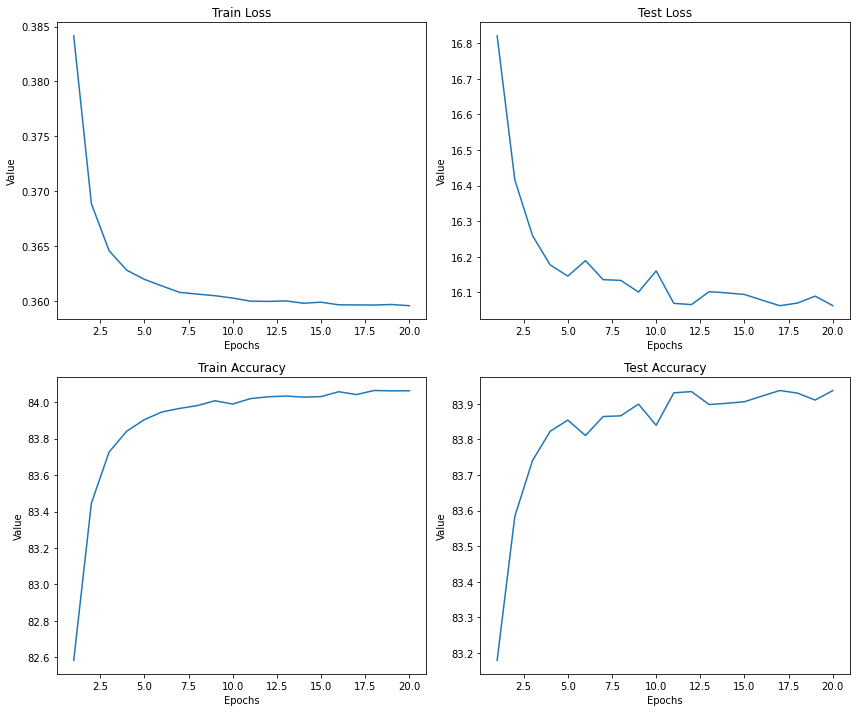

In [19]:
metrics = {
    "Train Loss": train_losses,
    "Test Loss": test_losses1,
    "Train Accuracy": train_accuracies,
    "Test Accuracy": test_accuracies1
}

plt.figure(figsize=(12, 10))

for i, (title, values) in enumerate(metrics.items(), 1):
    plt.subplot(2, 2, i)
    plt.plot(range(1, len(values) + 1), values)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [20]:
# Testing the model
with torch.no_grad():
    outputs = model(X_test_tfidf)
    predicted = torch.round(outputs)
    test_accuracy = accuracy_score(y_test_tfidf.cpu(), predicted.cpu())
    print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')
    
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test_tfidf.cpu(), predicted.cpu()))

Accuracy on test set: 83.91%
Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.86      0.84    350820
         1.0       0.85      0.82      0.84    349180

    accuracy                           0.84    700000
   macro avg       0.84      0.84      0.84    700000
weighted avg       0.84      0.84      0.84    700000



In [21]:
torch.save(model.state_dict(), r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\SNN_model_state_v3.pth')

In [22]:
torch.save(model, r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\SNN_model_v3.pth')

In [25]:
load_model = torch.load(r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\SNN_model_state_v3.pth')

# Testing the model
with torch.no_grad():
    outputs = load_model(X_test_tfidf)
    predicted = torch.round(outputs)
    test_accuracy = accuracy_score(y_test_tfidf.cpu(), predicted.cpu())
    print(f'Accuracy on test set: {test_accuracy * 100:.2f}%')
    
    
    # Classification report
    print("Classification Report:")
    print(classification_report(y_test_tfidf.cpu(), predicted.cpu()))

TypeError: 'collections.OrderedDict' object is not callable

In [24]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on the test set
y_pred = xgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

XGBoostError: [15:59:59] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\common\io.h:232: bad_malloc: Failed to allocate 1433600000 bytes.

  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

LogisticRegression
True Positive(TP)  =  244792 40.8
False Positive(FP) =  50009 8.33
True Negative(TN)  =  249443 41.57
False Negative(FN) =  55756 9.29
Accuracy of the binary classification = 0.824
              precision    recall  f1-score   support

           0       0.82      0.83      0.83    299452
           1       0.83      0.81      0.82    300548

    accuracy                           0.82    600000
   macro avg       0.82      0.82      0.82    600000
weighted avg       0.82      0.82      0.82    600000



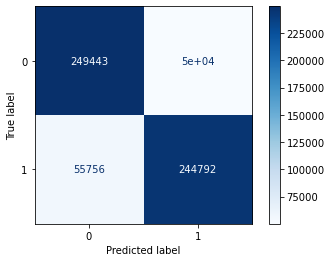

 25%|████████████████████                                                            | 1/4 [53:20<2:40:00, 3200.15s/it]

MultinomialNB
True Positive(TP)  =  232807 38.8
False Positive(FP) =  54166 9.03
True Negative(TN)  =  245286 40.88
False Negative(FN) =  67741 11.29
Accuracy of the binary classification = 0.797
              precision    recall  f1-score   support

           0       0.78      0.82      0.80    299452
           1       0.81      0.77      0.79    300548

    accuracy                           0.80    600000
   macro avg       0.80      0.80      0.80    600000
weighted avg       0.80      0.80      0.80    600000



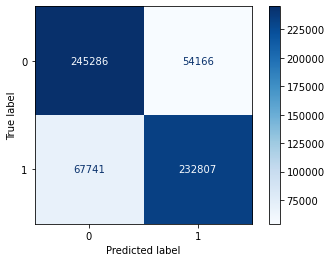

 50%|█████████████████████████████████████████                                         | 2/4 [55:00<45:53, 1376.86s/it]

LinearSVC
True Positive(TP)  =  244036 40.67
False Positive(FP) =  49312 8.22
True Negative(TN)  =  250140 41.69
False Negative(FN) =  56512 9.42
Accuracy of the binary classification = 0.824
              precision    recall  f1-score   support

           0       0.82      0.84      0.83    299452
           1       0.83      0.81      0.82    300548

    accuracy                           0.82    600000
   macro avg       0.82      0.82      0.82    600000
weighted avg       0.82      0.82      0.82    600000



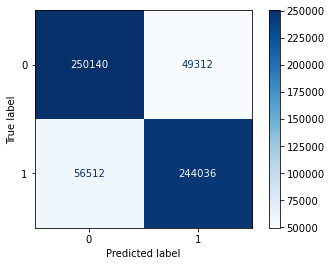

 75%|██████████████████████████████████████████████████████████████▎                    | 3/4 [57:28<13:35, 815.83s/it]

Perceptron
True Positive(TP)  =  199980 33.33
False Positive(FP) =  35047 5.84
True Negative(TN)  =  264405 44.07
False Negative(FN) =  100568 16.76
Accuracy of the binary classification = 0.774
              precision    recall  f1-score   support

           0       0.72      0.88      0.80    299452
           1       0.85      0.67      0.75    300548

    accuracy                           0.77    600000
   macro avg       0.79      0.77      0.77    600000
weighted avg       0.79      0.77      0.77    600000



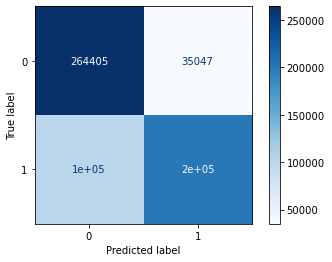

100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [1:01:52<00:00, 928.20s/it]


In [23]:
from tqdm import tqdm

lr = LogisticRegression(max_iter = 400)
mn = MultinomialNB()
svc = LinearSVC()
perc = Perceptron()

model_list = [lr, mn, svc, perc]
accuracy_list = []
for model in tqdm(model_list):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
    print(model.__class__.__name__)
    print('True Positive(TP)  = ', TP, np.round(TP / (TP+FP+TN+FN) * 100, 2))
    print('False Positive(FP) = ', FP, np.round(FP / (TP+FP+TN+FN) * 100, 2))
    print('True Negative(TN)  = ', TN, np.round(TN / (TP+FP+TN+FN) * 100, 2))
    print('False Negative(FN) = ', FN, np.round(FN / (TP+FP+TN+FN) * 100, 2))
    accuracy =  (TP+TN) /(TP+FP+TN+FN)
    print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))
    print(classification_report(y_test,predictions))
    accuracy_list.append(accuracy)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)  
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

In [37]:
def compare_models(x,y,label):
    plt.rcParams["figure.figsize"] = (12,8)
    ax = sns.barplot(x=x,y=y)
    # Annotate y value0s on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
            ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    # Add labels and title
    plt.xlabel('Models')
    plt.ylabel(label)
    plt.title(f'{label} for Different Regression Models')
    
    
## Compare R2 Values
x=['LR','MNB','SVC','Perceptron','XGB','SNN']
y=np.array(accuracy_list+[.829,.839])*100


compare_models(x,y,'Accuracy')

NameError: name 'accuracy_list' is not defined

The The Sequencial NN model gives the best Recall, f1-score, and accuracy value. Therefore we select LR model

## Realtime Prediction

In [26]:
class SequentialModel(nn.Module):
    def __init__(self, input_dim):
        super(SequentialModel, self).__init__()
        self.seq_model = nn.Sequential(
            nn.Linear(input_dim, 128, bias=False),
            nn.Dropout(p=0.5),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):

        return self.seq_model(inputs)

# Instantiate the model
load_model = SequentialModel(input_dim=512)


In [28]:
import joblib
vectorization = joblib.load(r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\TFIDF_vectorization_v2.pkl') 

load_model.load_state_dict(torch.load(r'C:\Users\hp\Desktop\AIDI\CAPSTONE\results\SNN_model_state_v3.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

In [29]:
text = "I love this item"
# text = clean_text(text)
print('-------------------------------')
print('Input Review = ',text)
print('-------------------------------')
text = vectorization.transform([text])
text = torch.tensor(text.toarray(), dtype=torch.float32)#.to(device)

-------------------------------
Input Review =  I love this item
-------------------------------


In [30]:
a = load_model(text)[0]
a

tensor([0.9983], grad_fn=<SelectBackward0>)

In [37]:
a.cpu().detach().numpy()

array([0.9983241], dtype=float32)